# Vidya Machine Learning Developer Practical Test

Este Jupyter Notebook é voltado para o teste do processo seletivo para vaga de Analista de IA Jr. na Vidya Technology.

Autor: Guilherme Henrique da Silva
E-mail: guilherme.utf@gmail.com

O objetivo deste notebook é ter um modelo de classificação usando os dados de https://www.kaggle.com/competitions/digitrecognizer/overview.

Este é o dataset MNIST, que consiste em imagens de números manuscritos, usado amplamente em contextos de Machine Learning para avaliar a capacidade de classificação de modelos.

Os dados são portanto imagens, o que torna o problema do campo de Visão Computacional.

# Download dos dados e EDA (Exploratory Data Analysis)

Primeiramente, vamos olhar os dados e sua estrutura para entender melhor o problema.

In [ ]:
import gdown
url = "https://drive.google.com/drive/folders/1_lkQb0GoESpbSjxeY5qzyDA2Iu2jYZoM?usp=drive_link"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/digit-recognizer/sample_submission.csv',
 '/content/digit-recognizer/test.csv',
 '/content/digit-recognizer/train.csv']

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

Printando algumas linhas dos dados de treino e teste:

In [ ]:
train_data = pd.read_csv('digit-recognizer/train.csv')
test_data = pd.read_csv('digit-recognizer/test.csv')
print(train_data.head())
print(test_data.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

A estrutura dos dados é bem simples. Possuem formato de tabela em que cada linha representa uma imagem e os valores em cada coluna de uma linha são os valores dos pixels da imagem. Nos dados de treino também há uma coluna com o label da imagem, ou seja, o algarismo que a imagem representa.

In [ ]:
print(len(train_data))
print(len(test_data))

42000
28000


Conclui-se então que há 42000 imagens com labels, e 28000 imagens sem labels que poderão ser usadas para testar o modelo.

É importante analisar quantas imagens existem para cada classe no dataset. Caso haja desbalanceamento, seria necessário o uso de técnicas que evitem o enviesamento do modelo.

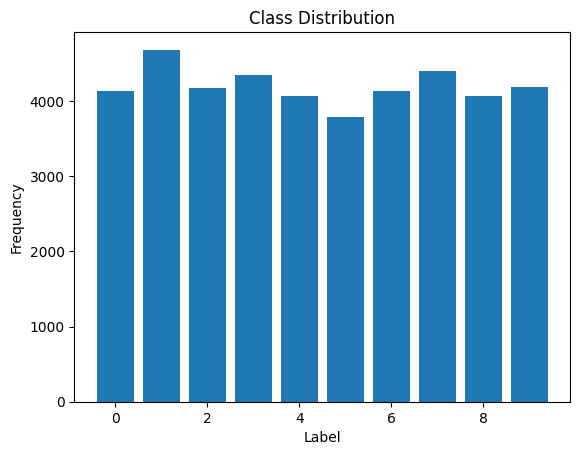

In [ ]:
class_counts = train_data['label'].value_counts().sort_index()
plt.bar(class_counts.index, class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

A distribuição de classes mostra que o dataset é bem equilibrado.

Vamos agora dar uma olhada em uma amostra de alguns dados:

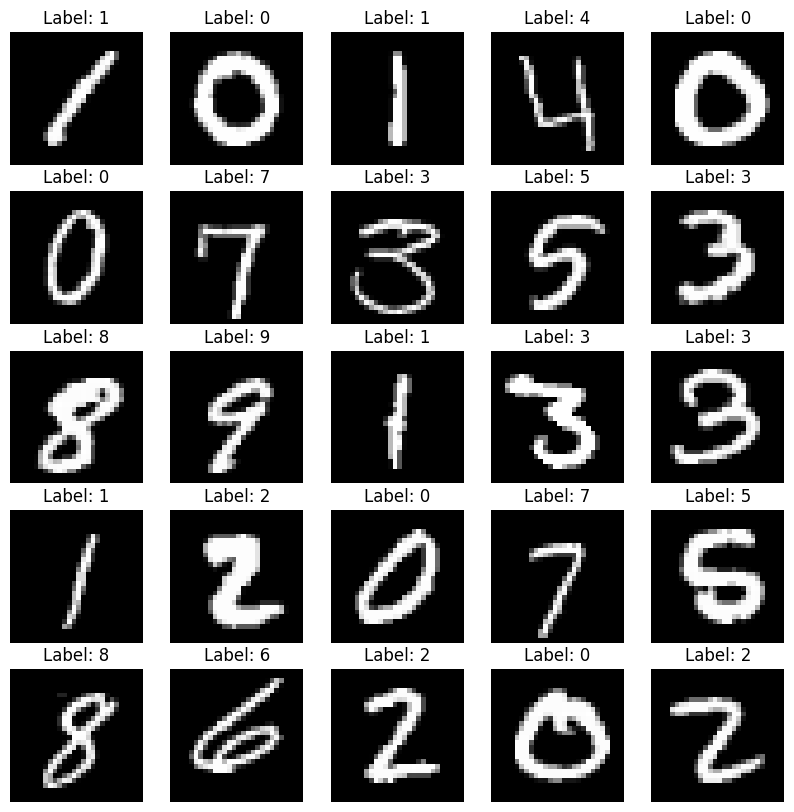

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    img = train_data.drop('label', axis=1).iloc[i].values.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {train_data['label'].iloc[i]}")
    plt.axis('off')
plt.show()

Como esperado, cada linha da tabela representa uma imagem, e, nos dados de treino, existe uma coluna com o algarismo que a imagem representa.

Os labels são números inteiros de 0 a 9, mas para o modelo é mais interessante que ele não faça a predição direta do número, mas sim das probabilidades para cada número. Essa é uma prática comum em Machine Learning para problemas de classificação, pois se o modelo tentar prever os números diretamente (0, 1, 2, ..., 9) ele pode interpretar isso como um problema de regressão e estabelecer uma relação numérica entre as classes. Para que o modelo veja cada classe como independente, uma das técnicas mais utilizadas é o One-Hot Encoding: uma representação binária para múltiplas classes que envolve criar uma matriz onde cada classe é representada por um vetor binário exclusivo. Dessa forma, o modelo irá tentar prever uma probabilidade para cada classe.

## Pré-processamento

Sendo assim, vamos fazer as transformações necessárias. Também vamos dividir os dados com label em dados de treino e validação. Ter uma parte dos dados para validação é fundamental para entender se o modelo está generalizando bem durante o treinamento, pois em cada época avalia-se o modelo em dados que não foram usados para treinar, além de ele ser necessário para avaliarmos a classificação do modelo posteriormente, já que os dados de teste não possuem labels.

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Separar as features e os labels
X_train = train_data.drop('label', axis=1).values
y_train = train_data['label'].values

X_test = test_data.values

# Normalizar os valores dos pixels
X_train = X_train / 255.0
X_test = X_test / 255.0

# Redimensionar (necessário para a CNN)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Converter os labels para one-hot encoding
y_train = to_categorical(y_train, num_classes=10)

# Dividir os dados de treino em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(len(X_train), len(X_val), len(X_test))

33600 8400 28000


Também normalizamos as imagens para o intervalo de 0 a 1. Isso é comum em pré-processamento de imagens, pois assim os modelos tendem a convergir melhor.

Temos portanto 33600 imagens de treino e 8400 de validação, além de 28000 imagens de teste.

## Modelo

Agora vamos definir o modelo. Para este problema, vários tipos de modelo podem ser usados, como SVM, modelos de clustering ou redes neurais lineares, além das redes neurais convolucionais (CNNs). Por se tratar de imagens, escolhi usar uma CNN, pois esse tipo de modelo tem ótimo desempenho em tarefas de reconhecimento de imagem. Vamos então definir um modelo de CNN simples:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Definir o modelo
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compilar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

A função de perda (loss) escolhida é apropriada para problemas de classificação multiclasse onde as classes são independentes. Ela mede a divergência entre a distribuição prevista e a verdadeira. Já o otimizador "adam" é bastante popular pois consegue fazer o modelo convergir bem sem ser necessário modificar muitos parâmetros. Para uma análise inicial é o mais recomendado. Posteriormente, para uma análise mais aprofundada, pode-se usar outros otimizadores e alterar parâmetros como a taxa de aprendizado ao longo do treinamento para otimizar os resultados.

## Treinamento

Para salvar o melhor modelo, vamos definir um Callback que salva sempre que o modelo melhorar sua classificação, baseado na função de perda dos dados de validação. Um menor valor de perda significa um maior valor de acerto das predições.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_filepath = 'best_model.keras'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

E então vamos para o treinamento. Foi definido uma quantidade de 10 épocas.

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_callback]  # Passar o callback aqui
)

Epoch 1/10
1038/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8349 - loss: 0.5158
Epoch 1: val_loss improved from inf to 0.05762, saving model to best_model.keras
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8361 - loss: 0.5123 - val_accuracy: 0.9830 - val_loss: 0.0576
Epoch 2/10
1047/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9779 - loss: 0.0737
Epoch 2: val_loss improved from 0.05762 to 0.04074, saving model to best_model.keras
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9779 - loss: 0.0737 - val_accuracy: 0.9868 - val_loss: 0.0407
Epoch 3/10
1040/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0503
Epoch 3: val_loss improved from 0.04074 to 0.03873, saving model to best_model.keras
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9852 - loss: 0.0503 - val_accuracy: 0.9876 - val_loss: 0.0387
Epoch 4/10
1043/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.0387
Epoch 4: val_loss improved from 0.0387

Na sua melhor época, o modelo teve uma perda de 0.02612 e uma acurácia de 99.15%. Vamos então carregar o modelo e avaliá-lo.

In [ ]:
best_model = tf.keras.models.load_model('best_model.keras')

## Resultados

Confirmando que carregamos o melhor modelo:

In [ ]:
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f'Validation Accuracy of the Best Model: {val_accuracy:.4f}')

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9893 - loss: 0.0322
Validation Accuracy of the Best Model: 0.9915


Agora vamos fazer um relatório das classificações do modelo para as 8400 imagens de validação:

In [ ]:
y_pred = model.predict(X_val)  # Substitua X_val pelo seu conjunto de teste, se necessário
y_pred_labels = np.argmax(y_pred, axis=1)  # Converte as previsões em rótulos de classe
y_true_labels = np.argmax(y_val, axis=1)

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true_labels, y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       816
           1       0.99      1.00      0.99       909
           2       0.99      0.99      0.99       846
           3       0.98      0.99      0.99       937
           4       0.99      0.99      0.99       839
           5       0.99      0.99      0.99       702
           6       0.99      0.99      0.99       785
           7       0.99      0.99      0.99       893
           8       0.99      0.99      0.99       835
           9       0.99      0.97      0.98       838

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



Como observado, o modelo teve uma média de 99% em todas as métricas, acurácia, precisão, f1-score e recall. Isso indica que o modelo está classificando bem todas as classes. Para entender melhor isso, vamos plotar a matriz de confusão:

263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


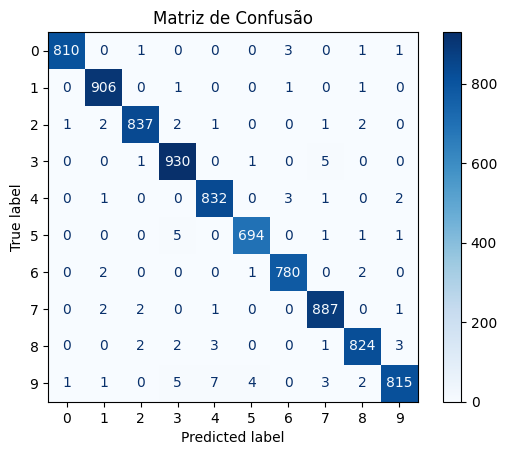

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Fazer previsões no conjunto de validação
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

# Calcular a matriz de confusão
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

Conclui-se que a grande maioria das imagens foram preditas corretamente. Os maiores erros são no número 9, que em 7 vezes o modelo classificou como 4.

## Teste

Agora vamos olhar algumas predições nos dados de teste:

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


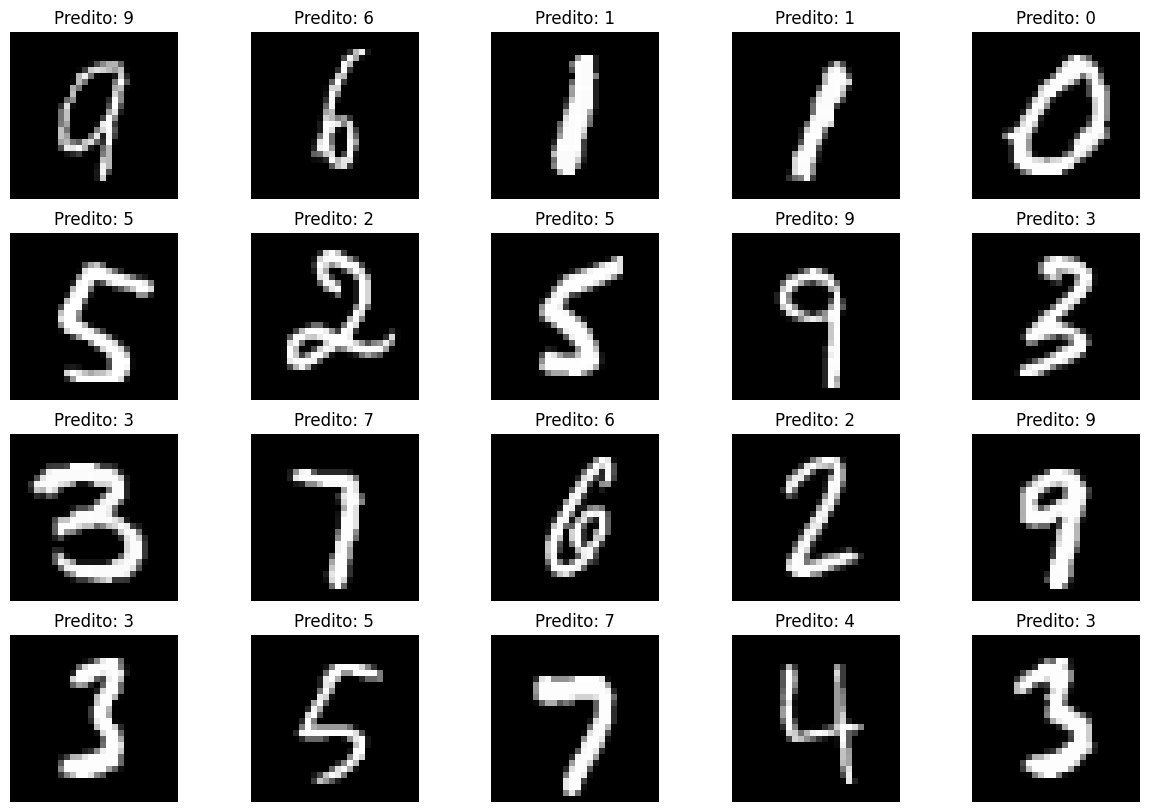

In [ ]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Selecionar algumas amostras aleatórias
num_samples = 20  # Número de amostras a serem exibidas
indices = np.random.choice(len(X_test), num_samples, replace=False)

# Plotar as amostras
plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Predito: {y_pred_labels[idx]}")
    plt.axis('off')
plt.show()

Nesses dados mostrados, todos foram preditos corretamente. Agora vamos salvar o modelo em formato .h5 para usarmos posteriormente em nossa aplicação.

In [ ]:
best_model.save('best_model.h5')